# Training with cropping to bounding boxes


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')


In [0]:
cd /content/gdrive/'My Drive'/KURSACH

/content/gdrive/My Drive/KURSACH


In [0]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import os
import sys
import tarfile
import numpy as np
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
#from IPython.display import display, Image, HTML
import h5py

%matplotlib inline

In [0]:
class TrainSVHN(Dataset):

    def __init__(self, csv_file, root_dir, transform=None):
        self.samples = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.samples.iloc[idx, 0])
        image = io.imread(img_name)
        #image = Image.open(img_name).convert('RGB')
        boxes = self.samples.iloc[idx, 1:5].values#as_matrix()
        length = self.samples.iloc[idx, 6]
        labels = self.samples.iloc[idx, 5]
        labels=labels.replace("[","").replace("]","")
        labels=labels.split(",")
        labels = np.asarray(labels)
        labels=labels.astype('float')
        labels = np.array(labels)
        boxes = boxes.astype('float').reshape(-1, 4)
        labels = labels.astype(int)
        labels[labels==10] = 0
        digits = np.full(5, 10, dtype=int)
        if (labels.shape[0] > 5) or (boxes[0][0]<0) or (boxes[0][1]<0) or (boxes[0][2]<0) or (boxes[0][3]<0):
          return self.__getitem__(idx+1)
        for i in range(labels.shape[0]):
          digits[i] = labels[i]
          
          
        labels = ''.join([str(i) for i in labels])
        labels = int(labels)
        labels = np.full(1,labels,dtype=int)
        #boxes = boxes.astype('float').reshape(-1, 4)
        length = int(length)
        length = np.full(1,length,dtype=int)
        sample = {'image': image, 'boxes': boxes, 'length': length, 'labels': labels, 'digits':digits}

        if self.transform:
            sample = self.transform(sample)

        return sample
       
  
import matplotlib.patches as patches
def display_bbox(image, boxes, length, labels, digits):
    fig, ax = plt.subplots(1)
    #plt.imshow(np.squeeze(image))
    plt.imshow(image)
    print('BOXES:',boxes[0])
    print('Length:',length)
    print('True label:',labels)
    print('Digits:',digits)
    rect = patches.Rectangle((boxes[0][0],boxes[0][3]),boxes[0][2]-boxes[0][0],boxes[0][1]-boxes[0][3],edgecolor='g',facecolor='none',lw=3) 
    ax.add_patch(rect)
    ax.grid(False)
    plt.show()
      

In [0]:
class Rescale(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, boxes = sample['image'], sample['boxes']
        length = sample['length']
        labels = sample['labels']
        digits = sample['digits']
        #w, h = image.size
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
               new_h, new_w = self.output_size, self.output_size
        new_h, new_w = int(new_h), int(new_w)

        image = transform.resize(image, (new_h, new_w), mode='reflect',anti_aliasing=True)
        boxes = boxes * [new_w / w, new_h / h, new_w / w, new_h / h]

        return {'image': image, 'boxes': boxes,'length': length,'labels': labels,'digits':digits}
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, boxes = sample['image'], sample['boxes']
        length = sample['length']
        labels = sample['labels']
        digits = sample['digits']
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'boxes': torch.from_numpy(boxes),'length':  length,'labels': torch.from_numpy(labels),'digits':torch.from_numpy(digits) }

In [0]:
class RandomCrop(object):

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, boxes = sample['image'], sample['boxes']
        length = sample['length']
        labels = sample['labels']
        digits = sample['digits']
        #w, h = image.size
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
       # new_h = boxes[0][1]-boxes[0][3]
        #new_w = boxes[0][2]-boxes[0][0]
       
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        boxes = boxes - [left, top, left, top]

        return {'image': image, 'boxes': boxes,'length': length,'labels': labels,'digits':digits}

In [0]:
from skimage.util import crop
class CropToBbox(object):

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, boxes = sample['image'], sample['boxes']
        length = sample['length']
        labels = sample['labels']
        digits = sample['digits']
        #print(boxes)
        #w, h = image.size
        h, w = image.shape[:2]
        height = int(boxes[0][1]-boxes[0][3])
        width = int(boxes[0][2]-boxes[0][0])
        x1 = int(boxes[0][0])
        x2 = int(boxes[0][1])
        y1 = int(boxes[0][2])
        y2 = int(boxes[0][3])
        #print(boxes[0])
        if height<0:
          height=-height
        image = image[x2:x2+height, x1:x1+width]
        #image = transform.resize(image, (54, 54), mode='constant',anti_aliasing=True)
        boxes = boxes - [x1, x2, x1, x2]

        return {'image': image, 'boxes': boxes,'length': length,'labels': labels,'digits':digits}

In [0]:
transformed_dataset_train = TrainSVHN(csv_file='data/bounding_boxes_train.csv',
                                    root_dir='data/train/',
                                           transform=transforms.Compose([
                                            CropToBbox(54), Rescale(54)#, RandomCrop(54),#,
                                            #ToTensor() #, transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
                                           ]))
train_loader = DataLoader(transformed_dataset_train,batch_size=4,
                        shuffle=True, num_workers=4)

In [0]:
for i in range(len(transformed_dataset_train)):
  sample = transformed_dataset_train[i]
  print(i)
  display_bbox(**sample)

BOXES: [ 0.  0. 54. 54.]
Length: [3]
True label: [104]
Digits: [ 1  0  4 10 10]


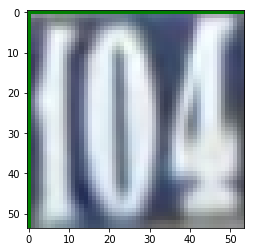

In [0]:
sample = transformed_dataset_train[2070]
display_bbox(**sample)

In [0]:
for i in range(len(transformed_dataset_train)):
    sample = transformed_dataset_train[i]

    print(i, sample['image'].size(), sample['boxes'].size())

    if i == 3:
        break

0 torch.Size([3, 54, 54]) torch.Size([1, 4])
1 torch.Size([3, 54, 54]) torch.Size([1, 4])
2 torch.Size([3, 54, 54]) torch.Size([1, 4])
3 torch.Size([3, 54, 54]) torch.Size([1, 4])


In [0]:
def show_boxes_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, boxes_batch = \
            sample_batched['image'], sample_batched['boxes']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    fig, ax = plt.subplots(1)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    #print(im_size)
    #for i in range(batch_size):
        #rect = patches.Rectangle((boxes_batch[i][0][0].numpy() + i * im_size,boxes_batch[i][0][3].numpy() ),boxes_batch[i][0][2].numpy() - boxes_batch[i][0][0].numpy()+i*batch_size,boxes_batch[i][0][1].numpy() - boxes_batch[i][0][3].numpy(),edgecolor='g',facecolor='none',lw=3) 
        #ax.add_patch(rect)
       # plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
          #          landmarks_batch[i, :, 1].numpy(),
          #          s=10, marker='.', c='r')

    plt.title('Batch from dataloader')

<Figure size 432x288 with 0 Axes>

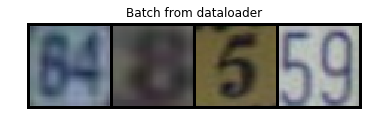

In [0]:
for i_batch, sample_batched in enumerate(train_loader):
    #print(i_batch, sample_batched['image'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_boxes_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

In [0]:
transformed_dataset_train = TrainSVHN(csv_file='data/bounding_boxes_train.csv',
                                    root_dir='data/train/',
                                           transform=transforms.Compose([
                                              CropToBbox(54), Rescale(54),
                                              ToTensor() #, transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
                                           ]))
train_loader = DataLoader(transformed_dataset_train,batch_size=4,
                        shuffle=True, num_workers=4)

In [0]:
device = torch.device("cuda:0")

In [0]:
class Model(nn.Module): #картинка 54x54
    def __init__(self):
        super(Model, self).__init__()

        hidden1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=48, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_features=48),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.Dropout(0.2)
        )
        hidden2 = nn.Sequential(
            nn.Conv2d(in_channels=48, out_channels=64, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1, padding=1),
            nn.Dropout(0.2)
        )
        hidden3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.Dropout(0.2)
        )
        hidden4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=160, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_features=160),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1, padding=1),
            nn.Dropout(0.2)
        )
        hidden5 = nn.Sequential(
            nn.Conv2d(in_channels=160, out_channels=192, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_features=192),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.Dropout(0.2)
        )
        hidden6 = nn.Sequential(
            nn.Conv2d(in_channels=192, out_channels=192, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_features=192),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1, padding=1),
            nn.Dropout(0.2)
        )
        hidden7 = nn.Sequential(
            nn.Conv2d(in_channels=192, out_channels=192, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_features=192),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.Dropout(0.2)
        )
        hidden8 = nn.Sequential(
            nn.Conv2d(in_channels=192, out_channels=192, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_features=192),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1, padding=1),
            nn.Dropout(0.2)
        )
        hidden9 = nn.Sequential(
            nn.Linear(192 * 7 * 7, 3072),
            nn.ReLU()
        )
        hidden10 = nn.Sequential(
            nn.Linear(3072, 3072),
            nn.ReLU()
        )

        self._features = nn.Sequential(
            hidden1,
            hidden2,
            hidden3,
            hidden4,
            hidden5,
            hidden6,
            hidden7,
            hidden8
        )
        self._classifier = nn.Sequential(
            hidden9,
            hidden10
        )
        self._digit_length = nn.Sequential(nn.Linear(3072, 7))
        self._digit1 = nn.Sequential(nn.Linear(3072, 11))
        self._digit2 = nn.Sequential(nn.Linear(3072, 11))
        self._digit3 = nn.Sequential(nn.Linear(3072, 11))
        self._digit4 = nn.Sequential(nn.Linear(3072, 11))
        self._digit5 = nn.Sequential(nn.Linear(3072, 11))

    def forward(self, x):
        x = self._features(x)
        x = x.view(x.size(0), 192 * 7 * 7)
        x = self._classifier(x)

        length_logits, digits_logits = self._digit_length(x), [self._digit1(x),
                                                               self._digit2(x),
                                                               self._digit3(x),
                                                               self._digit4(x),
                                                               self._digit5(x)]
        return length_logits, digits_logits

In [0]:
def _loss(length_logits, digits_logits, length_labels, digits_labels):
    length_cross_entropy = torch.nn.functional.cross_entropy(length_logits, length_labels)
    digit1_cross_entropy = torch.nn.functional.cross_entropy(digits_logits[0], digits_labels[:,0])
    digit2_cross_entropy = torch.nn.functional.cross_entropy(digits_logits[1], digits_labels[:,1])
    digit3_cross_entropy = torch.nn.functional.cross_entropy(digits_logits[2], digits_labels[:,2])
    digit4_cross_entropy = torch.nn.functional.cross_entropy(digits_logits[3], digits_labels[:,3])
    digit5_cross_entropy = torch.nn.functional.cross_entropy(digits_logits[4], digits_labels[:,4])
    loss = length_cross_entropy + digit1_cross_entropy + digit2_cross_entropy + digit3_cross_entropy + digit4_cross_entropy + digit5_cross_entropy
    return loss

In [0]:
model = Model()
model.to(device)
import time
from datetime import datetime
from torch.autograd import Variable

In [0]:
import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)


In [0]:
num_steps_to_show_loss = 1000
num_steps_to_check = 3000
step = 0
best_accuracy = 0.0
duration = 0.0
batch_size=4
learning_rate = 0.001

In [0]:
NPATH = 'data/FINALLY.pth'

In [0]:
evaluator = Evaluator()

In [0]:
for epoch in range(30):  # loop over the dataset multiple times
  for i, sample_batched in enumerate(train_loader):
    start_time = time.time()
    images = sample_batched['image']
    length_labels = sample_batched['length']
    digits_labels = sample_batched['digits']
    images = images.float()
    length_labels = length_labels.type(torch.LongTensor)
    length_labels.squeeze_()
    #print(length_labels)
    #digits_labels = digits_labels.float()
    #digits_labels = digits_labels.squeeze_()
    #print(digits_labels)
   
    images, length_labels, digits_labels = (Variable(images.cuda()),
                                                    Variable(length_labels.cuda()),
                                                    Variable(digits_labels.cuda()))
    length_logits, digits_logits = model.train()(images)
    loss = _loss(length_logits, digits_logits, length_labels, digits_labels)
    optimizer.zero_grad()
    loss.backward() 
    optimizer.step()
    step += 1
    duration += time.time() - start_time
    if step % num_steps_to_show_loss == 0:
      examples_per_sec = batch_size * num_steps_to_show_loss / duration
      duration = 0.0
      print('=> %s: step %d, loss = %f, learning_rate = %f (%.1f examples/sec)' % (
      datetime.now(), step, loss.data, learning_rate, examples_per_sec))
    
    if step % num_steps_to_check == 0:
      accuracy = evaluator.evaluate(model)
      print('==> accuracy = %f, best accuracy %f' % (accuracy, best_accuracy))
      if accuracy > best_accuracy:
        torch.save(model.state_dict(), NPATH)
        print('=> Model saved to file: %s' % NPATH)
        best_accuracy = accuracy

=> 2019-05-09 19:31:04.062042: step 1000, loss = 7.070109, learning_rate = 0.010000 (145.2 examples/sec)
=> 2019-05-09 19:35:04.924644: step 2000, loss = 5.753783, learning_rate = 0.010000 (144.2 examples/sec)
==> accuracy = 0.060453, best accuracy 0.000000
=> Model saved to file: data/FINALLY.pth
=> 2019-05-09 20:53:21.988356: step 3000, loss = 4.799528, learning_rate = 0.010000 (143.9 examples/sec)
=> 2019-05-09 20:57:28.585686: step 4000, loss = 3.639361, learning_rate = 0.010000 (143.5 examples/sec)
==> accuracy = 0.140190, best accuracy 0.060453
=> Model saved to file: data/FINALLY.pth
=> 2019-05-09 21:02:50.685147: step 5000, loss = 3.494287, learning_rate = 0.010000 (141.9 examples/sec)
=> 2019-05-09 21:06:40.184401: step 6000, loss = 2.505445, learning_rate = 0.010000 (144.9 examples/sec)
==> accuracy = 0.231788, best accuracy 0.140190
=> Model saved to file: data/FINALLY.pth
=> 2019-05-09 21:11:56.274105: step 7000, loss = 2.682281, learning_rate = 0.010000 (145.8 examples/sec

In [0]:
PATH = 'data/FINALLY.pth'
NPATH = 'data/FINALLY_2.pth'
model = Model()
model.load_state_dict(torch.load(PATH))
model.cuda()


In [0]:
for epoch in range(30):  # loop over the dataset multiple times
  for i, sample_batched in enumerate(train_loader):
    start_time = time.time()
    images = sample_batched['image']
    length_labels = sample_batched['length']
    digits_labels = sample_batched['digits']
    images = images.float()
    length_labels = length_labels.type(torch.LongTensor)
    length_labels.squeeze_()
    #print(length_labels)
    #digits_labels = digits_labels.float()
    #digits_labels = digits_labels.squeeze_()
    #print(digits_labels)
   
    images, length_labels, digits_labels = (Variable(images.cuda()),
                                                    Variable(length_labels.cuda()),
                                                    Variable(digits_labels.cuda()))
    length_logits, digits_logits = model.train()(images)
    loss = _loss(length_logits, digits_logits, length_labels, digits_labels)
    optimizer.zero_grad()
    loss.backward() 
    optimizer.step()
    step += 1
    duration += time.time() - start_time
    if step % num_steps_to_show_loss == 0:
      examples_per_sec = batch_size * num_steps_to_show_loss / duration
      duration = 0.0
      print('=> %s: step %d, loss = %f, learning_rate = %f (%.1f examples/sec)' % (
      datetime.now(), step, loss.data, learning_rate, examples_per_sec))
    
    if step % num_steps_to_check == 0:
      accuracy = evaluator.evaluate(model)
      print('==> accuracy = %f, best accuracy %f' % (accuracy, best_accuracy))
      if accuracy > best_accuracy:
        torch.save(model.state_dict(), NPATH)
        print('=> Model saved to file: %s' % NPATH)
        best_accuracy = accuracy

=> 2019-05-10 15:09:05.151660: step 1000, loss = 0.993730, learning_rate = 0.010000 (163.0 examples/sec)
=> 2019-05-10 15:12:36.535523: step 2000, loss = 0.059316, learning_rate = 0.010000 (167.9 examples/sec)
=> 2019-05-10 15:15:58.910948: step 3000, loss = 0.011888, learning_rate = 0.010000 (167.4 examples/sec)
==> accuracy = 0.867769, best accuracy 0.000000
=> Model saved to file: data/FINALLY_2.pth
=> 2019-05-10 16:51:04.888211: step 4000, loss = 0.008989, learning_rate = 0.010000 (164.9 examples/sec)
=> 2019-05-10 16:54:22.162497: step 5000, loss = 0.035714, learning_rate = 0.010000 (167.7 examples/sec)
=> 2019-05-10 16:57:47.318333: step 6000, loss = 0.039606, learning_rate = 0.010000 (164.2 examples/sec)
==> accuracy = 0.869605, best accuracy 0.867769
=> Model saved to file: data/FINALLY_2.pth
=> 2019-05-10 17:02:48.970935: step 7000, loss = 1.249841, learning_rate = 0.010000 (167.4 examples/sec)
=> 2019-05-10 17:06:09.518089: step 8000, loss = 0.348918, learning_rate = 0.010000

KeyboardInterrupt: ignored

**Точность - 87.3431 % используя для обучения только train датасет**

In [0]:
transformed_dataset_train = TrainSVHN(csv_file='data/bounding_boxes_extra.csv',
                                    root_dir='data/extra/',
                                           transform=transforms.Compose([
                                              CropToBbox(54), Rescale(54),
                                              ToTensor() #, transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
                                           ]))
extra_loader = DataLoader(transformed_dataset_train,batch_size=4,
                        shuffle=True, num_workers=4)

In [0]:
num_steps_to_show_loss = 1000
num_steps_to_check = 5000
step = 0
best_accuracy = 0.0
duration = 0.0
batch_size=4
learning_rate = 0.01

In [0]:
PATH = 'data/FINALLY_2.pth'
NPATH = 'data/FINALLY_EXTRA.pth'
model = Model()
model.load_state_dict(torch.load(PATH))
model.cuda()


In [0]:
for epoch in range(5):  # loop over the dataset multiple times
  for i, sample_batched in enumerate(extra_loader):
    start_time = time.time()
    images = sample_batched['image']
    length_labels = sample_batched['length']
    digits_labels = sample_batched['digits']
    images = images.float()
    length_labels = length_labels.type(torch.LongTensor)
    length_labels.squeeze_()
    #print(length_labels)
    #digits_labels = digits_labels.float()
    #digits_labels = digits_labels.squeeze_()
    #print(digits_labels)
   
    images, length_labels, digits_labels = (Variable(images.cuda()),
                                                    Variable(length_labels.cuda()),
                                                    Variable(digits_labels.cuda()))
    length_logits, digits_logits = model.train()(images)
    loss = _loss(length_logits, digits_logits, length_labels, digits_labels)
    optimizer.zero_grad()
    loss.backward() 
    optimizer.step()
    step += 1
    duration += time.time() - start_time
    if step % num_steps_to_show_loss == 0:
      examples_per_sec = batch_size * num_steps_to_show_loss / duration
      duration = 0.0
      print('=> %s: step %d, loss = %f, learning_rate = %f (%.1f examples/sec)' % (
      datetime.now(), step, loss.data, learning_rate, examples_per_sec))
    
    if step % num_steps_to_check == 0:
      accuracy = evaluator.evaluate(model)
      print('==> accuracy = %f, best accuracy %f' % (accuracy, best_accuracy))
      if accuracy > best_accuracy:
        torch.save(model.state_dict(), NPATH)
        print('=> Model saved to file: %s' % NPATH)
        best_accuracy = accuracy

In [0]:
transformed_dataset_test = TrainSVHN(csv_file='data/bounding_boxes_test.csv',
                                    root_dir='data/test/',
                                           transform=transforms.Compose([
                                             CropToBbox(54),#, Rescale(54),
                                              ToTensor() #, transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
                                           ]))
train_loader = DataLoader(transformed_dataset_test,batch_size=4,
                        shuffle=False, num_workers=4)

In [0]:
def _infer(path_to_checkpoint_file, path_to_input_image):
    model = Model()
   # model.restore(path_to_checkpoint_file)
    model.load_state_dict(torch.load(path_to_checkpoint_file))
    model.eval()
    model.cuda()

    with torch.no_grad():
        transform = transforms.Compose([
            transforms.Resize([64, 64]),
            transforms.CenterCrop([54, 54]),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])

        image = Image.open(path_to_input_image)
        image = image.convert('RGB')
        image = transform(image)
        images = image.unsqueeze(dim=0).cuda()
        #print(model.eval()(images))
        #length_logits, digit1_logits, digit2_logits, digit3_logits, digit4_logits, digit5_logits = model.eval()(images)
        length_logits, digits_logits = model.eval()(images)

        length_prediction = length_logits.max(1)[1]
        #print(digits_logits[1].max(1)[1].item())
        #digits_prediction = digits_logits.max(1)[1]
        digit1_prediction = digits_logits[0].max(1)[1]
        digit2_prediction = digits_logits[1].max(1)[1]
        digit3_prediction = digits_logits[2].max(1)[1]
        digit4_prediction = digits_logits[3].max(1)[1]
        digit5_prediction = digits_logits[4].max(1)[1]

        print('length:', length_prediction.item())
        print('digits:', digit1_prediction.item(), digit2_prediction.item(), digit3_prediction.item(), digit4_prediction.item(), digit5_prediction.item())

In [0]:
def imshow(img):
    img = io.imread(img)
    plt.imshow(img)
    plt.show()

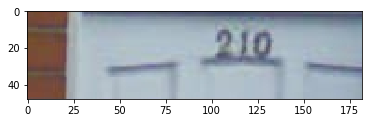

In [0]:
IMAGE = 'data/test/2.png'
#_infer(PATH,IMAGE)
imshow(IMAGE)

In [0]:
class Evaluator(object):
    def __init__(self):
        transform = transforms.Compose([
            transforms.CenterCrop([54, 54]),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])
        transformed_dataset_test = TrainSVHN(csv_file='data/bounding_boxes_test.csv',
                                    root_dir='data/test/',
                                           transform=transforms.Compose([
                                                CropToBbox(54), Rescale(54),
                                              ToTensor() #, transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
                                           ]))
        self._loader = torch.utils.data.DataLoader(transformed_dataset_test, batch_size=4, shuffle=False)

    def evaluate(self, model):
        num_correct = 0
        needs_include_length = False

        with torch.no_grad():
            for i,  sample_batched in enumerate(self._loader):
                images = sample_batched['image']
                length_labels = sample_batched['length']
                digits_labels = sample_batched['digits']
                #print(digits_labels)
                images = images.float()
                length_labels = length_labels.type(torch.LongTensor)
                length_labels.squeeze_()
                images, length_labels, digits_labels = images.cuda(), length_labels.cuda(),  digits_labels.cuda()
                length_logits, digits_logits = model.eval()(images)

                length_prediction = length_logits.max(1)[1]
                digit1_prediction = digits_logits[0].max(1)[1]
                digit2_prediction = digits_logits[1].max(1)[1]
                digit3_prediction = digits_logits[2].max(1)[1]
                digit4_prediction = digits_logits[3].max(1)[1]
                digit5_prediction = digits_logits[4].max(1)[1]

                
                num_correct += (length_prediction.eq(length_labels) &
                                    digit1_prediction.eq(digits_labels[:,0]) &
                                    digit2_prediction.eq(digits_labels[:,1]) &
                                    digit3_prediction.eq(digits_labels[:,2]) &
                                    digit4_prediction.eq(digits_labels[:,3]) &
                                    digit5_prediction.eq(digits_labels[:,4])).cuda().sum()
        accuracy = num_correct.item() / len(self._loader.dataset)
        return accuracy